In [1]:
import jieba
import time
import scipy as sp
import sklearn
from sklearn.linear_model import SGDClassifier

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

STOPWORD = { u"的", u"了", u"在", u"是", u"我", u"有", u"和", u"就",  
        u"不", u"人", u"都", u"一", u"一个", u"上", u"也", u"很", u"到", u"说", u"要", u"去", u"你",  
        u"会", u"着", u"没有", u"看", u"好", u"自己", u"这" }

In [2]:
# -*- coding:gb2312 -*-
#print train_data.split('\t')[3]#.decode("utf-8").encode("gbk")

In [3]:
test_data = []
with open("weibo_predict_data.txt") as infile:
    for line in infile.readlines():
        line = line.split('\t')
        tmp = {"uid": line[0], "mid":line[1], "time":line[2], "content":line[3]}
        test_data.append(tmp)

In [4]:
train_data = []
with open("weibo_train_data.txt") as infile:
    for line in infile.readlines():
        line = line.split('\t')
        tmp = {"uid": line[0], "mid":line[1], "time":line[2], "forward_count":int(line[3]), 
               "comment_count":int(line[4]), "like_count": int(line[5]), "content":line[6]}
        train_data.append(tmp)

In [5]:
train_uids = set([train_data[i]["uid"] for i in xrange(len(train_data))])

In [6]:
test_uids = set([test_data[i]["uid"] for i in xrange(len(test_data))])

In [7]:
print len(train_uids), len(test_uids), len(train_uids & test_uids), len(train_uids | test_uids), len(test_uids - train_uids)

45671 24818 23604 46885 1214


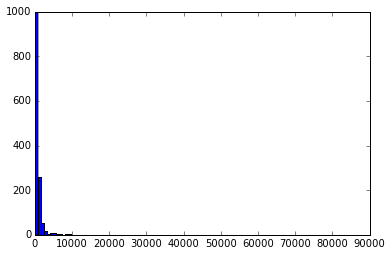

In [8]:
plt.hist(([train_data[i]["forward_count"] for i in xrange(len(train_data)) if train_data[i]["forward_count"]!=0]), 
         bins=100)
plt.ylim([0,1000])
plt.show()

In [9]:
len([train_data[i]["forward_count"] for i in xrange(len(train_data))])

1626750


##BUILD MODEL

In [10]:
import random
start = time.time()
training_data = []
training_labels = []
all_words = {}
random.shuffle(train_data)
for i in xrange(len(train_data[0:20000])):
    if i%10000==0: print i
    if train_data[i]["forward_count"]<1:
        training_labels.append(1)
        
    else:
        training_labels.append(0)
    
    tmp_dict= {}
    for word in jieba.cut(train_data[i]["content"], cut_all=False):
        if word in STOPWORD: continue
        if not all_words.has_key(word): all_words[word]=0
        if not tmp_dict.has_key(word): tmp_dict[word]=0
        tmp_dict[word]+=1
        all_words[word]+=1
    
    training_data.append(tmp_dict)

print "Time Elapsed:", (time.time()-start)

Building prefix dict from /Users/toby/anaconda/lib/python2.7/site-packages/jieba/dict.txt ...
DEBUG:jieba:Building prefix dict from /Users/toby/anaconda/lib/python2.7/site-packages/jieba/dict.txt ...
Loading model from cache /var/folders/bq/svz9rm5s3x5clz2bzxzqmhd00000gp/T/jieba.cache
DEBUG:jieba:Loading model from cache /var/folders/bq/svz9rm5s3x5clz2bzxzqmhd00000gp/T/jieba.cache
Loading model cost 0.554 seconds.
DEBUG:jieba:Loading model cost 0.554 seconds.
Prefix dict has been built succesfully.
DEBUG:jieba:Prefix dict has been built succesfully.


0
10000
Time Elapsed: 11.1711220741


In [11]:
sum(np.array(training_labels)==1)

16680

In [12]:
index_to_word = []
word_to_index = {}
for key, value in all_words.iteritems():
    word_to_index[key] = len(index_to_word)
    index_to_word.append(key)

In [13]:
start = time.time()
all_data_matrix = np.zeros(shape = [len(training_data), len(word_to_index)])
for index, words in enumerate(training_data):
    for word, value in words.iteritems():
        all_data_matrix[index][word_to_index[word]] = value
        
train_matrix = all_data_matrix[0:len(all_data_matrix)*3/4]
test_matrix = all_data_matrix[len(all_data_matrix)*3/4:]
train_label = training_labels[0:len(all_data_matrix)*3/4]
test_label = training_labels[len(all_data_matrix)*3/4:]

#train_matrix = sp.sparse.csc_matrix(all_data_matrix[0:len(all_data_matrix)*3/4])
#test_matrix = sp.sparse.csc_matrix(all_data_matrix[len(all_data_matrix)*3/4:])

        
print "Time Elapsed:", time.time()-start

Time Elapsed: 1.31136608124


In [14]:
start = time.time()
classifier = SGDClassifier(loss='hinge', penalty='l2', alpha=1e-3, n_iter=5, random_state=42)
classifier.fit(train_matrix, train_label)
print "Time Elapsed:", (time.time()-start)
print "Accuracy is", np.mean(classifier.predict(test_matrix)==test_label)

Time Elapsed: 12.2032101154
Accuracy is 0.836


In [15]:
for word in jieba.cut(train_data[i]["content"], cut_all=False):
    if word in STOPWORD: continue
    if word==u"的": break
    print word

@
焦
豆豆
cs
 
今天
肿
么
加班
。
。
。




In [16]:
for i in xrange(len(train_data)):
    if train_data[i]["uid"]=='e640551a1764e35999211df55994f58e':# and "@" in train_data[i]["content"]:
        print train_data[i]["content"], train_data[i]["like_count"]

#咕咚智能手环2#告诉我，我从2014年8月6日 21:30 到 8月7日 23:10,走了 13072 步，2671 米，燃烧 461.7 大卡; 睡眠 6 小时 40 分钟。这是我的数据图表，快来@咕咚网 和我PK一下！ http://t.cn/RPoaHGB
0
点赞抢100M4G流量，分享活动还可抽可口可乐！速速参加！http://t.cn/RzSR6DX
0
#咕咚智能手环2#告诉我，我从2014年8月10日 22:20 到 8月11日 12:50,走了 3450 步，2769 米，燃烧 123.3 大卡; 睡眠 5 小时 20 分钟。这是我的数据图表，快来@咕咚网 和我PK一下！ http://t.cn/RPpDyg6
0
Hi，我在用mo生活客户端，海量商品在线即可购买，现金、话费都能支付，还有各种折扣信息、生活资讯，感觉真的很赞，想赶紧与你分享下！下载地址是 http://t.cn/8sRbZZX ，发送短信“A”至106585855，也可以获取下载链接，你快试试吧！
0
江苏移动mo生活客户端刮刮乐又来袭，话费、品牌礼金券、电影礼金券免费送，关注微信：shlm12580 更有机会赢400元话费。马上分享给小伙伴们吧！下载地址是   http://t.cn/8sRbZZX  ，发送短信“A”至106585855，也可以获取下载链接。
0
「#金龙鱼阳光葵花籽油##欧洲阳光Style公益跑#阳光奔跑，跬步大爱，6430份母亲邮包，让改变，在贫困妈妈身边，悄然发生。http://t.cn/RPoXaNl」下载咕咚:http://t.cn/RvXqyLY
0
Hi，我在使用mo生活客户端，海量商品在线即可购买，现金、话费都能支付，还有各种折扣信息、生活资讯，感觉真的很赞，想赶紧与你分享下！下载地址是   http://t.cn/8sRbZZX  ，发送短信“A”至106585855，也可以获取下载链接，你快试试吧！
0
关于@咕咚网 的投票【#世界杯咕咚神预测#比利时VS美国比分竞猜】，挺赞的！先转给你们，大家帮我投一票吧：http://t.cn/Rvm8WgZ
0
【江苏移动又送福利啦】盆友们赶紧一起来砍价抢流量，世界杯官方手机SONY T2分分钟砍到不要钱，还有流量免费抢，最大10个G！流量不是梦，眼红快行动！！ http://t.cn/RvxuHlk